In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import mutual_info_regression

%matplotlib inline

In [2]:
wholesale_data = pd.read_csv("../data/Wholesale_customers_data.csv")

In [3]:
sales_data = wholesale_data.drop(["Region", "Channel"], axis=1)

In [4]:
sales_data_scaled = (sales_data - sales_data.mean())/sales_data.std()

In [5]:
sales_data.columns

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

In [6]:
def PMI(i1, i2):
    return mutual_info_regression(wholesale_data[[i1]], wholesale_data[i2])[0]

In [8]:
def PMIs(features):
    pairwise_indices = list(combinations(features, 2))
    pmis = []
    for pair in pairwise_indices:
        pmis.append((pair, PMI(*pair)))
    return pmis

In [9]:
PMIs(sales_data.columns)

[(('Fresh', 'Milk'), 0.057847283765329216),
 (('Fresh', 'Grocery'), 0.017193868417916258),
 (('Fresh', 'Frozen'), 0.04803147642420802),
 (('Fresh', 'Detergents_Paper'), 0.011452717084922126),
 (('Fresh', 'Delicassen'), 0.0029882049924812026),
 (('Milk', 'Grocery'), 0.25483302385319706),
 (('Milk', 'Frozen'), 0),
 (('Milk', 'Detergents_Paper'), 0.1921377779510347),
 (('Milk', 'Delicassen'), 0.06863087818986613),
 (('Grocery', 'Frozen'), 0.03642661268098091),
 (('Grocery', 'Detergents_Paper'), 0.49261557543530676),
 (('Grocery', 'Delicassen'), 0.02542755701883137),
 (('Frozen', 'Detergents_Paper'), 0.050466797854304524),
 (('Frozen', 'Delicassen'), 0.0018799431099059127),
 (('Detergents_Paper', 'Delicassen'), 0)]

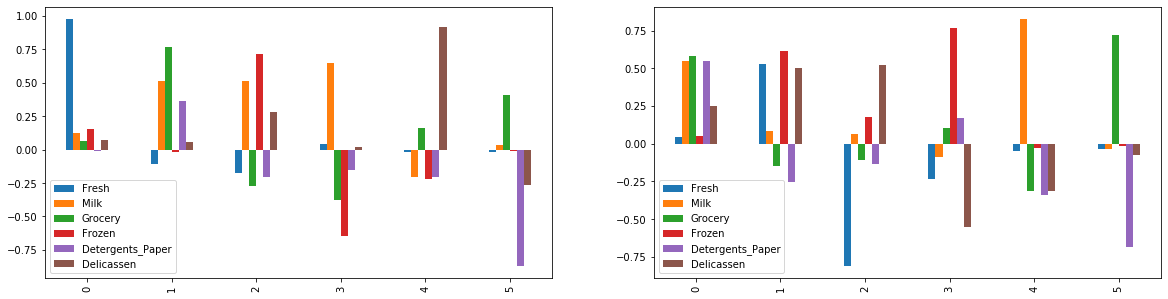

In [10]:
fig, ax = plt.subplots(1,2,figsize =(20,5))

pca = PCA(n_components=6)
lrm = pd.DataFrame(pca.fit_transform(sales_data), columns = ["pc_1", "pc_2", "pc_3", "pc_4", "pc_5", "pc_6"])
pca_sc = PCA(n_components=6)
lrm_sc = pd.DataFrame(pca_sc.fit_transform(sales_data_scaled), columns = ["pc_1", "pc_2", "pc_3", "pc_4", "pc_5", "pc_6"])

loadings = pd.DataFrame(pca.components_, columns=sales_data.columns)
loadings.plot(kind="bar", ax=ax[0])
loadings_sc = pd.DataFrame(pca_sc.components_, columns=sales_data.columns)
loadings_sc.plot(kind="bar", ax=ax[1])

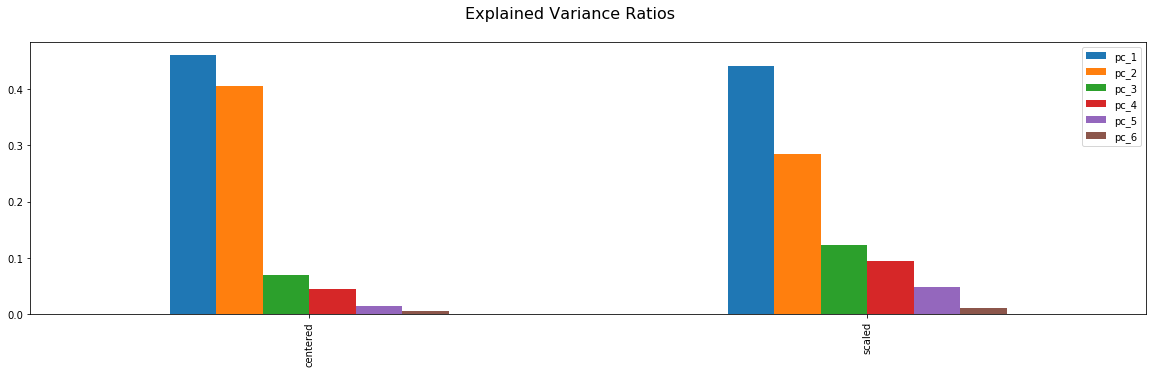

In [11]:
fig, ax = plt.subplots(1,1,figsize =(20,5))
fig.suptitle(f'Explained Variance Ratios', fontsize=16)
exV = pd.DataFrame([pd.Series(pca.explained_variance_ratio_), pd.Series(pca_sc.explained_variance_ratio_)])
exV.columns = ["pc_1", "pc_2", "pc_3", "pc_4", "pc_5", "pc_6"]
exV.index = ["centered", "scaled"]
exV.plot(kind="bar", ax=ax)
fig.savefig("../data/exV.png")

In [12]:
loadings.T[0]["Fresh"]

0.976536845621806

In [13]:
def coherence(lrm_vector):
    coherence_value = 0
    for pmi in PMIs(sales_data.columns):
        (feature_1, feature_2), value = pmi
        loading_feature_1 = lrm_vector[feature_1]
        loading_feature_2 = lrm_vector[feature_2]
        coherence_value += np.abs(loading_feature_1)*np.abs(loading_feature_2)*value
    return coherence_value

In [14]:
for i in range(6):
    print(coherence(loadings.T[i]))
print()
for i in range(6):
    print(coherence(loadings_sc.T[i]))

0.018207343764138927
0.28530142852364465
0.12271310850002216
0.1264696342934466
0.05479704052331724
0.1902405354943591

0.31167100898960143
0.06473548796254272
0.029267642970806335
0.04292378856441206
0.19836681694554315
0.2608364338911296


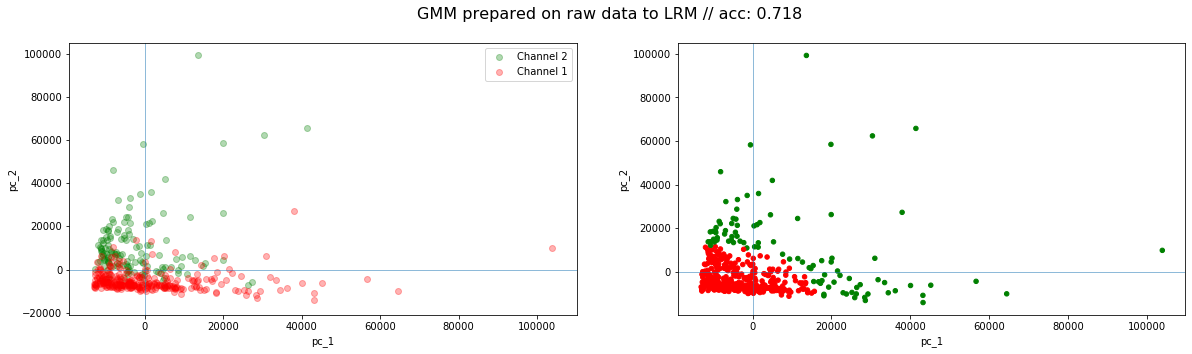

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
features = ["pc_1", "pc_2"]
gmm = GaussianMixture(n_components=2)
model = lrm
labels = gmm.fit_predict(model[features])
accuracy = np.mean(np.array(["red" if label == 0 else "green" for label in labels]) == np.array(["red" if label == 1 else "green" for label in wholesale_data.Channel]))
fig.suptitle(f'GMM prepared on raw data to LRM // acc: {round(accuracy, 3)}', fontsize=16)
for val in wholesale_data.Channel.unique():
    topic_1 = model[wholesale_data.Channel == val][features[0]].values
    topic_2 = model[wholesale_data.Channel == val][features[1]].values
    color = "red" if val == 1 else "green"
    label = "Channel 1" if val == 1 else "Channel 2"
    ax[0].scatter(topic_1, topic_2, c=color, alpha=0.3, label=label)

model.plot(kind="scatter", x=features[0], y=features[1], c=["red" if label == 0 else "green" for label in labels], ax=ax[1])
ax[0].set_xlabel('pc_1')
ax[0].set_ylabel('pc_2')
ax[0].axvline(linewidth=0.5)
ax[0].axhline(linewidth=0.5)
ax[1].axvline(linewidth=0.5)
ax[1].axhline(linewidth=0.5)
ax[0].legend()
fig.savefig("../data/plt1.png")

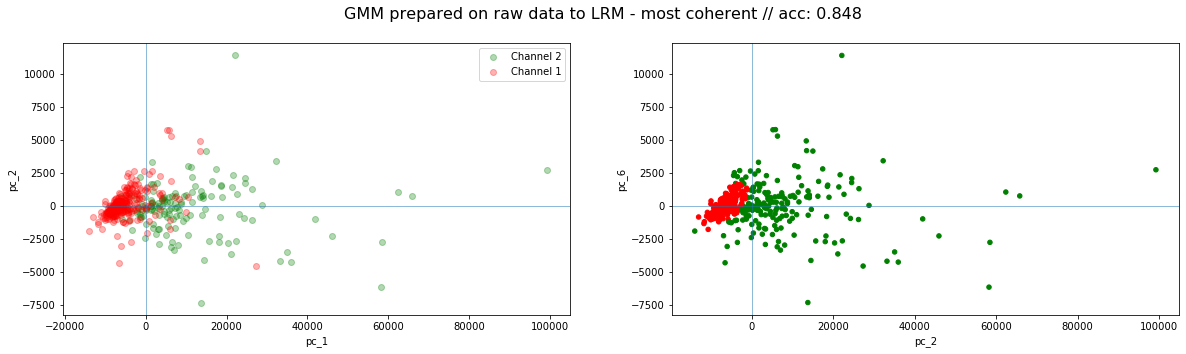

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
features = ["pc_2", "pc_6"]
gmm = GaussianMixture(n_components=2)
model = lrm
labels = gmm.fit_predict(model[features])

accuracy = np.mean(np.array(["red" if label == 0 else "green" for label in labels]) == np.array(["red" if label == 1 else "green" for label in wholesale_data.Channel]))
fig.suptitle(f'GMM prepared on raw data to LRM - most coherent // acc: {round(accuracy, 3)}', fontsize=16)

for val in wholesale_data.Channel.unique():
    topic_1 = model[wholesale_data.Channel == val][features[0]].values
    topic_2 = model[wholesale_data.Channel == val][features[1]].values
    color = "red" if val == 1 else "green"
    label = "Channel 1" if val == 1 else "Channel 2"
    ax[0].scatter(topic_1, topic_2, c=color, alpha=0.3, label=label)

model.plot(kind="scatter", x=features[0], y=features[1], c=["red" if label == 0 else "green" for label in labels], ax=ax[1])

ax[0].set_xlabel('pc_1')
ax[0].set_ylabel('pc_2')
ax[0].axvline(linewidth=0.5)
ax[0].axhline(linewidth=0.5)
ax[1].axvline(linewidth=0.5)
ax[1].axhline(linewidth=0.5)
ax[0].legend()
fig.savefig("../data/plt2.png")

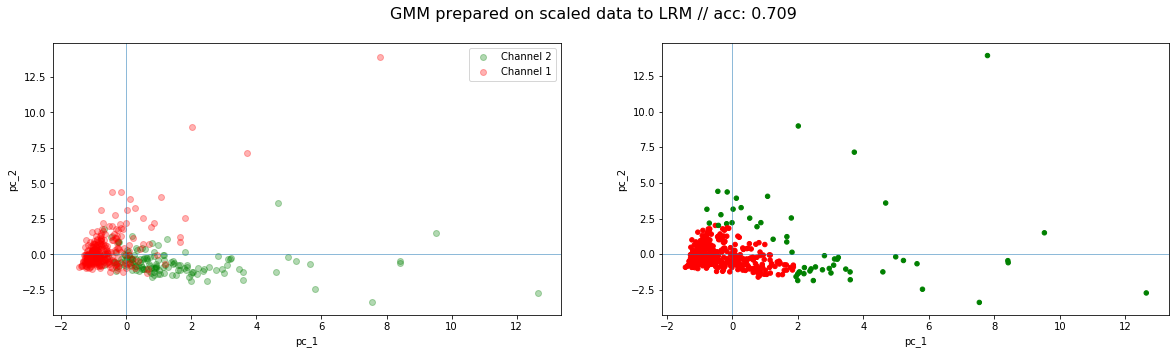

In [100]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
features = ["pc_1", "pc_2"]
gmm = GaussianMixture(n_components=2)
model = lrm_sc
labels = gmm.fit_predict(model[features])

accuracy = np.mean(np.array(["red" if label == 0 else "green" for label in labels]) == np.array(["red" if label == 1 else "green" for label in wholesale_data.Channel]))
fig.suptitle(f'GMM prepared on scaled data to LRM // acc: {round(accuracy, 3)}', fontsize=16)

for val in wholesale_data.Channel.unique():
    topic_1 = model[wholesale_data.Channel == val][features[0]].values
    topic_2 = model[wholesale_data.Channel == val][features[1]].values
    color = "red" if val == 1 else "green"
    label = "Channel 1" if val == 1 else "Channel 2"
    ax[0].scatter(topic_1, topic_2, c=color, alpha=0.3, label=label)

model.plot(kind="scatter", x=features[0], y=features[1], c=["red" if label == 0 else "green" for label in labels], ax=ax[1])

ax[0].set_xlabel('pc_1')
ax[0].set_ylabel('pc_2')
ax[0].axvline(linewidth=0.5)
ax[0].axhline(linewidth=0.5)
ax[1].axvline(linewidth=0.5)
ax[1].axhline(linewidth=0.5)
ax[0].legend()
fig.savefig("../data/plt3.png")

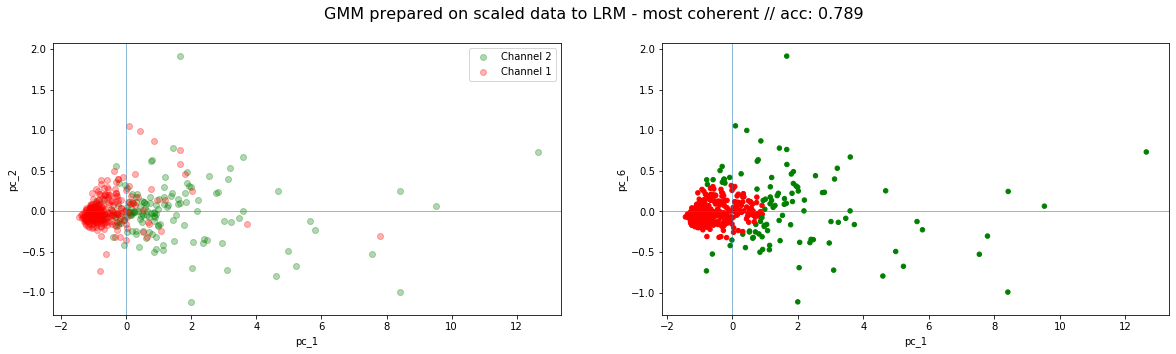

In [101]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
features = ["pc_1", "pc_6"]
gmm = GaussianMixture(n_components=2)
model = lrm_sc
labels = gmm.fit_predict(model[features])

accuracy = np.mean(np.array(["red" if label == 0 else "green" for label in labels]) == np.array(["red" if label == 1 else "green" for label in wholesale_data.Channel]))
fig.suptitle(f'GMM prepared on scaled data to LRM - most coherent // acc: {round(accuracy, 3)}', fontsize=16)

for val in wholesale_data.Channel.unique():
    topic_1 = model[wholesale_data.Channel == val][features[0]].values
    topic_2 = model[wholesale_data.Channel == val][features[1]].values
    color = "red" if val == 1 else "green"
    label = "Channel 1" if val == 1 else "Channel 2"
    ax[0].scatter(topic_1, topic_2, c=color, alpha=0.3, label=label)

model.plot(kind="scatter", x=features[0], y=features[1], c=["red" if label == 0 else "green" for label in labels], ax=ax[1])

ax[0].set_xlabel('pc_1')
ax[0].set_ylabel('pc_2')
ax[0].axvline(linewidth=0.5)
ax[0].axhline(linewidth=0.5)
ax[1].axvline(linewidth=0.5)
ax[1].axhline(linewidth=0.5)
ax[0].legend()
fig.savefig("../data/plt4.png")